In [600]:
import os
import numpy as np
import pandas as pd
import configparser
import matplotlib.pyplot as plt

config = configparser.ConfigParser()
config.read('CR10X_Varriable_Deffs.ini')

DataPath = config['DATA']['path']
subDirs = [x[0] for x in os.walk(DataPath)]
subDirs.remove(DataPath)

Sites = config['DATA']['Sites'].split(',')

# Get the header info from the .FSL file
def parse_FSL(file):
    Metadata = open(file)
    array_id = None
    TableDef = {}
    TableDef['AGG']=[]
    for line in Metadata.readlines():
        if line == '\n':
            array_id = None
        # Defines tables by array
        elif 'Output_Table' in line:
            array_id = int(line.split(' ')[0])
            TableDef[array_id]= []
        # Defines values for each array
        elif array_id is not None:
            rec = line.split(' ')[1]
            TableDef[array_id].append(rec)
            # Gets aggregation statistics (AGG)
            sp = rec.split('_')
            if len(sp)>1 and sp[-1] !='RTM' and sp[-1] not in TableDef['AGG']:

                TableDef['AGG'].append(sp[-1])
            
    return(TableDef)

def makeDateTime(df,year,doy,hrmn):
    df.loc[df[hrmn]==2400,hrmn]=0
    df['datetime'] = pd.to_datetime(
                df[year].astype(str) +'-' +
                df[doy].astype(str).str.zfill(3)+' '+
                df[hrmn].astype(str).str.zfill(4).str[:2]+':'+
                df[hrmn].astype(str).str.zfill(4).str[2:],
                format='%Y-%j %H:%M')
    df = df.set_index(pd.DatetimeIndex(df['datetime']))#,inplace=True,drop=True)
    df=df.drop([year,doy,hrmn,'datetime'],axis=1)
    return(df)

# Loop through sites, merge files to one .csv and rename headers
AllData = pd.DataFrame()
for site in Sites:
    DailyData = pd.DataFrame()
    HalfHourlyData = pd.DataFrame()
    TableDef = parse_FSL(config[site]['FSL'])
    for dir in subDirs:
        file = config['DATA']['FileName'].replace('{LOGGER}',site)
        data = pd.read_csv(f'{dir}/{file}',header=None,na_values=[-6999])
        # Half-hourly data
        HH_id = int(config[site]['30_Min'])
        HH = data.loc[data[0]==HH_id]
        for c in HH.columns:
            HH = HH.rename(columns={c:TableDef[HH_id][c].upper()})
        cols = [c for c in HH.columns]
        # Pattern match variables we want to rename
        for k in config[site].keys():
            k = k.upper()
            for stat in TableDef['AGG']:
                val = k.replace('AGG',stat)
                if val in cols:
                    name = config[site][k].replace('AGG',stat).replace('POS',site)
                    HH = HH.rename(columns={val:name})
        HH = HH.drop([str(HH_id)],axis=1)
        HH = makeDateTime(HH,'YEAR_RTM','DAY_RTM','HOUR_MINUTE_RTM')
        HH = HH.resample('30T').first()
        HH = HH.loc[HH.index.isin(HalfHourlyData.index)==False]
        HalfHourlyData = pd.concat([HalfHourlyData,HH])

        # Daily data
        DY_id = int(config[site]['Daily'])
        DY = data.loc[data[0]==DY_id]
        for c in DY.columns:
            try:
                DY = DY.rename(columns={c:TableDef[DY_id][c].upper()})
            except:
                DY = DY.drop(c,axis=1)
        cols = [c.upper() for c in DY.columns]
        # Pattern match variables we want to rename
        for k in config[site].keys():
            k = k.upper()
            for stat in TableDef['AGG']:
                val = k.replace('AGG',stat)
                if val in cols:
                    name = config[site][k].replace('AGG',stat).replace('POS',site)
                    DY = DY.rename(columns={val:name})
        DY = DY.drop([str(DY_id)],axis=1)
        DY = makeDateTime(DY,'YEAR_RTM','DAY_RTM','HOUR_MINUTE_RTM')
        DY = DY.resample('D').first()
        DY = DY.loc[DY.index.isin(DailyData.index)==False]
        DailyData = pd.concat([DailyData,DY])
    
    HalfHourlyData = HalfHourlyData.join(DailyData)
    
    AllData = pd.concat([AllData,HalfHourlyData],axis=1)

for i,d in enumerate(config['DATA']['SERVICE_DATES'].split(',')):
    d = pd.to_datetime(d).date()
    print(d)
    if i == 0:
        AllData=AllData.loc[AllData.index.date > d]
    else:
        AllData.loc[AllData.index.date == d] = np.nan
AllData.head()

2023-03-18
2023-03-21
2023-04-04


,PannelTemp_PSLS_AVG,TS_PSLS_S_5cm_AVG,TS_PSLS_S_10cm_AVG,TS_PSLS_S_30cm_AVG,TS_PSLS_R_5cm_AVG,TS_PSLS_R_10cm_AVG,TS_PSLS_R_30cm_AVG,Voltage_PSLS_MIN,PROGSIG_PSLS_AVG,PannelTemp_PSTS_AVG,...,Voltage_PSW_S_MIN,PROGSIG_PSW_S_AVG,PannelTemp_PSW_R_AVG,TS_PSW_R_5cm_AVG,TS_PSW_R_10cm_AVG,TS_PSW_R_30cm_AVG,VWC_PSW_R_AVG,PAUS_PSW_R_AVG,Voltage_PSW_R_MIN,PROGSIG_PSW_R_AVG
datetime,,,,,,,,,,,,,,,,,,,,,
2023-03-19 00:00:00,8.190,5.828,2.450,5.525,7.040,5.980,4.022,12.58,1898.0,7.560,...,12.34,196.1,7.170,6.171,5.403,4.938,0.847,40.90,12.55,3817.0
2023-03-19 00:30:00,1.173,5.359,2.137,6.010,6.422,6.413,4.531,NaN,NaN,0.948,...,NaN,NaN,-0.067,5.195,5.548,5.221,0.849,40.94,NaN,NaN
2023-03-19 01:00:00,0.814,5.405,1.997,6.014,6.159,6.380,4.548,NaN,NaN,0.578,...,NaN,NaN,-0.355,5.100,5.535,5.231,0.849,40.94,NaN,NaN
2023-03-19 01:30:00,0.516,5.296,2.074,5.964,5.932,6.277,4.481,NaN,NaN,0.261,...,NaN,NaN,-0.609,4.966,5.486,5.206,0.849,40.94,NaN,NaN
2023-03-19 02:00:00,0.274,5.333,1.863,5.881,5.824,6.335,4.249,NaN,NaN,-0.001,...,NaN,NaN,-0.803,4.836,5.439,5.189,0.849,40.94,NaN,NaN


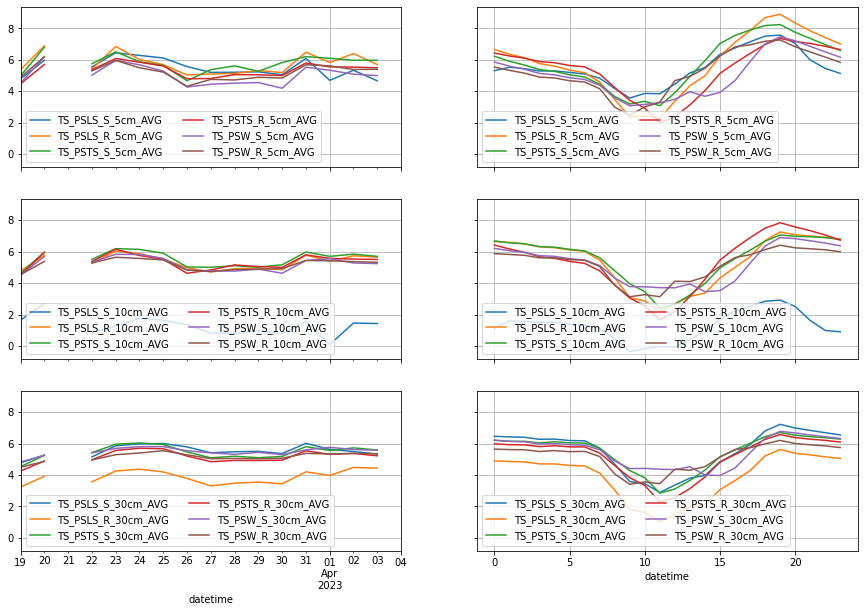

In [612]:
Positions = ['PSLS_S','PSLS_R','PSTS_S','PSTS_R','PSW_S','PSW_R']


fig,ax=plt.subplots(3,2,figsize=(15,10),sharey=True,sharex='col')

depths = ['5','10','30']

for i,depth in enumerate(depths):
    
    cols = [f'TS_{pos}_{depth}_AVG' for pos in Positions]
    AllData[cols].resample('D').mean().plot(ax=ax[i,0])
    ax[i,0].legend(ncol=2)
    ax[i,0].grid()
    AllData[cols].groupby(AllData.index.hour).mean().plot(ax=ax[i,1])
    ax[i,1].legend(ncol=2)
    ax[i,1].grid()

In [ ]:

DataPath = 'Z:\\BBS\\Loggerdata\\'

subDirs = [x[0] for x in os.walk(DataPath)]

subDirs.remove(DataPath)

TableDefs = {
    'PSLS':{
        
        },
    'PSTS':{
        'FSL':'TallShrub/PSTS.FSL'
        },
    'PSW_R':{
        'FSL':'Woodland/PSW_R.FSL'
        },
    'PSW_S':{
        'FSL':'Woodland/PSW_S.FSL'
        },
}

Loggers = list(TableDefs.keys())

# Read .FSL files for variable definitions
for key in Loggers:
    Metadata = open(TableDefs[key]['FSL'])
    array_id = None
    TableDefs[key]['ids']=[]
    for line in Metadata.readlines():
        if line == '\n':
            array_id = None
        elif 'Output_Table' in line:
            array_id = line.split(' ')[0]
            TableDefs[key]['ids'].append(int(array_id))
            TableDefs[key][array_id[-1]] = []
            DataTables[key][array_id[-1]] = pd.DataFrame()
        elif array_id is not None:
            TableDefs[key][array_id[-1]].append(line.split(' ')[1])

Data = pd.DataFrame()
Voltage = pd.DataFrame()

for dir in subDirs:
    for logger in Loggers:
        file = f'{dir}/CR10X_{logger}_final_storage_1.dat'
        raw = pd.read_csv(file,header=None,na_values=[-6999])
        for id in TableDefs[logger]['ids']:
            df = raw.loc[raw[0]==id]
            df = df.drop([0],axis=1)
            rename = {}
            for c in df.columns:
                try:
                    if TableDefs[logger][str(id)[-1]][c] not in [id,'Hour_Minute_RTM','Day_RTM','Year_RTM']:
                        name = TableDefs[logger][str(id)[-1]][c]+'_'+logger
                    else:
                        name = TableDefs[logger][str(id)[-1]][c]
                    rename[c]=name
                except:
                    pass
            df = df.rename(columns=rename)
            df.loc[df['Hour_Minute_RTM']==2400,'Hour_Minute_RTM']=0
            df['datetime'] = pd.to_datetime(
                        df['Year_RTM'].astype(str) +'-' +
                        df['Day_RTM'].astype(str).str.zfill(3)+' '+
                        df['Hour_Minute_RTM'].astype(str).str.zfill(4).str[:2]+':'+
                        df['Hour_Minute_RTM'].astype(str).str.zfill(4).str[2:],
                        format='%Y-%j %H:%M')
            df.set_index(pd.DatetimeIndex(df['datetime']),inplace=True,drop=True)
            df = df.resample('30T').max()
            Data = pd.concat([Data,df])
            # # Exclude values from before installation
Data = Data.loc[((Data.index.year>2023)|(Data.index.dayofyear>77))]
Data

In [379]:

TableDefs = {
    'PSLS':{
        'FSL':'LowShrub/PSLS.FSL'
        },
    'PSTS':{
        'FSL':'TallShrub/PSTS.FSL'
        },
    'PSW_R':{
        'FSL':'Woodland/PSW_R.FSL'
        },
    'PSW_S':{
        'FSL':'Woodland/PSW_S.FSL'
        },
}

DataTables = {
    'PSLS':{},
    'PSTS':{},
    'PSW_R':{},
    'PSW_S':{},

}

Change_Names = {
    'PSLS':{
    'Temp_C_AVG':'TS_S_5',
    'Temp_C_1_AVG':'TS_S_10',
    'Temp_C_2_AVG':'TS_S_30',
    'Temp_C_3_AVG':'TS_R_5',
    'Temp_C_4_AVG':'TS_R_10',
    'Temp_C_5_AVG':'TS_R_30'
            },
    'PSTS':{
    'Temp_C_AVG':'TS_S_5',
    'Temp_C_1_AVG':'TS_S_10',
    'Temp_C_2_AVG':'TS_S_30',
    'Temp_C_3_AVG':'TS_R_5',
    'Temp_C_4_AVG':'TS_R_10',
    'Temp_C_5_AVG':'TS_R_30'
            },
    'PSW_R':{
    'Temp_C_AVG':'TS_R_5',
    'Temp_C_1_AVG':'TS_R_10',
    'Temp_C_2_AVG':'TS_R_30'
    },
    'PSW_S':{
    'Temp_C_AVG':'TS_S_5',
    'Temp_C_1_AVG':'TS_S_10',
    'Temp_C_2_AVG':'TS_S_30'
    },

}

Loggers = list(TableDefs.keys())

for key in Loggers:
    
    Metadata = open(TableDefs[key]['FSL'])
    array_id = None
    TableDefs[key]['array_ids']=[]
    for line in Metadata.readlines():
        if line == '\n':
            array_id = None
        elif 'Output_Table' in line:
            array_id = line.split(' ')[0]
            TableDefs[key]['array_ids'].append(int(array_id))
            TableDefs[key][array_id[-1]] = []
            DataTables[key][array_id[-1]] = pd.DataFrame()
        elif array_id is not None:
            TableDefs[key][array_id[-1]].append(line.split(' ')[1])

TableDefs
for dir,subdirs,files in os.walk(Path):
    
    print(dir)
    for file in TableDefs.keys():
        # Ecosystem = (file.split('_')[1])
        # Treatment = ''
        # if file.split('_')[2] == 'R':
        #     Treatment = '_R'
        # elif file.split('_')[2] == 'S':
        #     Treatment = '_S'
        # Site = Ecosystem+Treatment
        raw = pd.read_csv(dir+'/'+file,header=None,na_values=[-6999])
        
        for id in TableDefs[Site]['array_ids']:
            df = raw.loc[raw[0]==id]
            rename = {}
            for c in df.columns:
                try:
                    if TableDefs[Site][str(id)[-1]][c] not in ['Hour_Minute_RTM','Day_RTM','Year_RTM']:
                        name = TableDefs[Site][str(id)[-1]][c]+'_'+Site
                    else:
                        name = TableDefs[Site][str(id)[-1]][c]
                    rename[c]=name
                except:
                    pass
            df = df.rename(columns=rename)
            df.loc[df['Hour_Minute_RTM']==2400,'Hour_Minute_RTM']=0
            df['Hour_Minute_RTM']=df['Hour_Minute_RTM'].astype(str).str.zfill(4)
            df['Day_RTM'] = df['Day_RTM'].astype(str).str.zfill(3)
            df['Year_RTM'] = df['Year_RTM'].astype(str)
            df['datetime'] = df['Year_RTM'] + '-' + df['Day_RTM']+' '+df['Hour_Minute_RTM'].str[:2]+':'+df['Hour_Minute_RTM'].str[2:]
            df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%j %H:%M')
            df.set_index(pd.DatetimeIndex(df['datetime']),inplace=True,drop=True)
            # df.drop(columns=[str(id)],inplace=True)
            df = pd.concat([DataTables[Site][str(id)[-1]],df])
            df = df.resample('30T').mean()
            # Exclude values from before installation
            df = df.loc[((df.index.year>2023)|(df.index.dayofyear>77))]
            for d in service_dates:
                df.loc[df.index.date == d] = np.nan
            DataTables[Site][str(id)[-1]] = df


# for Site in Loggers:
#     df = DataTables[Site]['1'].copy()
#     df = df.rename(columns=Change_Names[Site])
#     print(Site)
#     print(df[Change_Names[Site].values()].mean().round(1))
#     DataTables[Site]['1'] = df

Z:\BBS\Loggerdata\


FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\BBS\\Loggerdata\\/PSLS'

In [377]:
Change_Names

{'PSLS': {'Temp_C_AVG': 'TS_S_5',
  'Temp_C_1_AVG': 'TS_S_10',
  'Temp_C_2_AVG': 'TS_S_30',
  'Temp_C_3_AVG': 'TS_R_5',
  'Temp_C_4_AVG': 'TS_R_10',
  'Temp_C_5_AVG': 'TS_R_30'},
 'PSTS': {'Temp_C_AVG': 'TS_S_5',
  'Temp_C_1_AVG': 'TS_S_10',
  'Temp_C_2_AVG': 'TS_S_30',
  'Temp_C_3_AVG': 'TS_R_5',
  'Temp_C_4_AVG': 'TS_R_10',
  'Temp_C_5_AVG': 'TS_R_30'},
 'PSW_R': {'Temp_C_AVG': 'TS_R_5',
  'Temp_C_1_AVG': 'TS_R_10',
  'Temp_C_2_AVG': 'TS_R_30'},
 'PSW_S': {'Temp_C_AVG': 'TS_S_5',
  'Temp_C_1_AVG': 'TS_S_10',
  'Temp_C_2_AVG': 'TS_S_30'}}

Text(0.5, 0.98, 'Pine-Sphagnum Low-Shrub Soil Temps')

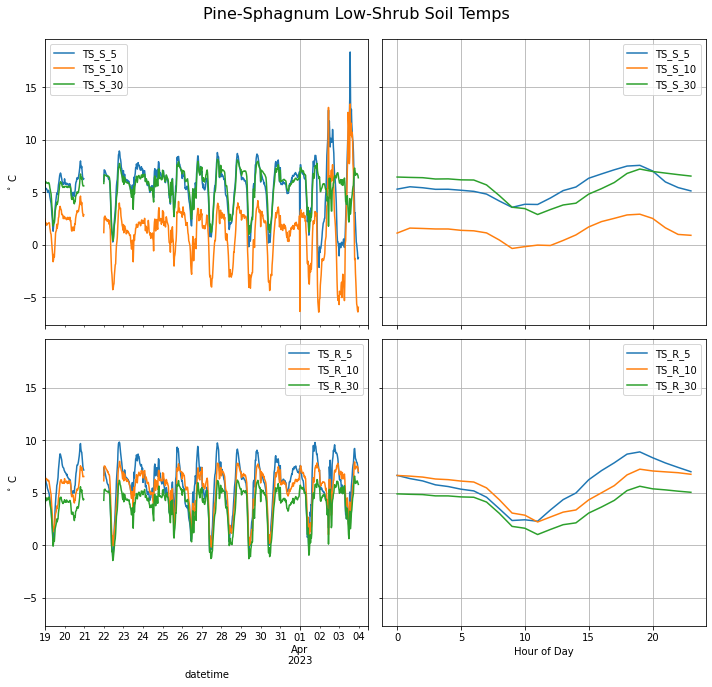

In [357]:
df = DataTables['PSLS']['1']
fig,ax=plt.subplots(2,2,figsize=(10,10),sharex='col',sharey=True)
df[['TS_S_5','TS_S_10', 'TS_S_30']].plot(ax=ax[0,0])
df[['TS_S_5','TS_S_10', 'TS_S_30']].groupby(df.index.hour).mean().plot(ax=ax[0,1])
df[['TS_R_5','TS_R_10', 'TS_R_30']].plot(ax=ax[1,0])
df[['TS_R_5','TS_R_10', 'TS_R_30']].groupby(df.index.hour).mean().plot(ax=ax[1,1])
ax[1,1].set_xlabel('Hour of Day')
for axes in ax:
    for a in axes:
        a.grid()
        a.set_ylabel('$^\circ$ C')
# fig.autofmt_xdate()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Pine-Sphagnum Low-Shrub Soil Temps',fontsize=16)

Text(0.5, 0.98, 'Pine-Sphagnum Tall-Shrub Soil Temps')

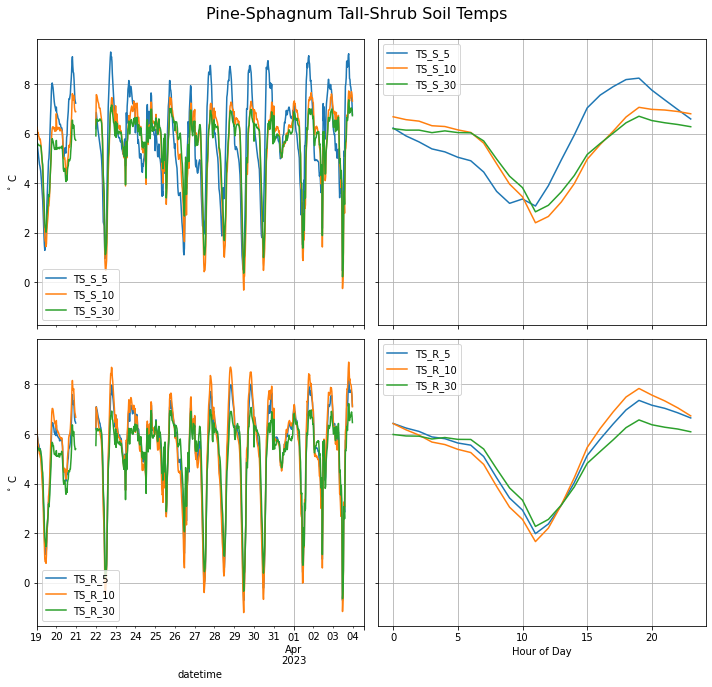

In [358]:
df = DataTables['PSTS']['1']
fig,ax=plt.subplots(2,2,figsize=(10,10),sharex='col',sharey=True)
df[['TS_S_5','TS_S_10', 'TS_S_30']].plot(ax=ax[0,0])
df[['TS_S_5','TS_S_10', 'TS_S_30']].groupby(df.index.hour).mean().plot(ax=ax[0,1])
df[['TS_R_5','TS_R_10', 'TS_R_30']].plot(ax=ax[1,0])
df[['TS_R_5','TS_R_10', 'TS_R_30']].groupby(df.index.hour).mean().plot(ax=ax[1,1])
ax[1,1].set_xlabel('Hour of Day')
for axes in ax:
    for a in axes:
        a.grid()
        a.set_ylabel('$^\circ$ C')
# fig.autofmt_xdate()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Pine-Sphagnum Tall-Shrub Soil Temps',fontsize=16)

Text(0.5, 0.98, 'Pine-Sphagnum Woodland Soil Temps')

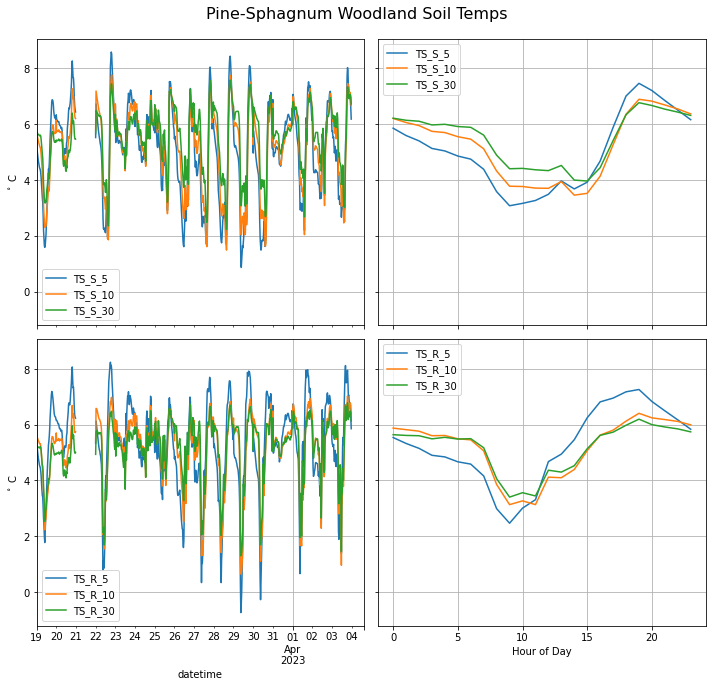

In [365]:
df = DataTables['PSW_S']['1']
fig,ax=plt.subplots(2,2,figsize=(10,10),sharex='col',sharey=True)
df[['TS_S_5','TS_S_10', 'TS_S_30']].plot(ax=ax[0,0])
df[['TS_S_5','TS_S_10', 'TS_S_30']].groupby(df.index.hour).mean().plot(ax=ax[0,1])
df = DataTables['PSW_R']['1']
df[['TS_R_5','TS_R_10', 'TS_R_30']].plot(ax=ax[1,0])
df[['TS_R_5','TS_R_10', 'TS_R_30']].groupby(df.index.hour).mean().plot(ax=ax[1,1])
ax[1,1].set_xlabel('Hour of Day')
for axes in ax:
    for a in axes:
        a.grid()
        a.set_ylabel('$^\circ$ C')
# fig.autofmt_xdate()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Pine-Sphagnum Woodland Soil Temps',fontsize=16)